<a href="https://colab.research.google.com/github/3srava0/Final_Project/blob/main/Sravan_PSVS_Week2_ResNet50_99_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import os
from pathlib import Path
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import models
import torch.optim as optim
import kagglehub
import copy
import time
from collections import OrderedDict
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 classes
model = model.to(device)

print("✅ ResNet50 initialized")


Using: cuda
✅ ResNet50 initialized


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Optional: LR decay


In [15]:


dataset_path = "/kaggle/input/leaf-based-tomato-plant-disease-recognition-data"
split_folder = "plant_disease_dataset_10_classes_split"  # Your actual name
splitroot = os.path.join(dataset_path, split_folder)

print("Checking splitroot:", splitroot)
train_path = os.path.join(splitroot, "train")
test_path = os.path.join(splitroot, "test")

print("Train exists:", os.path.exists(train_path))
print("Test exists:", os.path.exists(test_path))

# List contents if still missing
if os.path.exists(splitroot):
    print("splitroot contents:", os.listdir(splitroot))
if os.path.exists(train_path):
    print("train classes:", os.listdir(train_path)[:5])


Checking splitroot: /kaggle/input/leaf-based-tomato-plant-disease-recognition-data/plant_disease_dataset_10_classes_split
Train exists: False
Test exists: False
splitroot contents: ['plant_disease_dataset_10_classes_split']


In [17]:
dataset_path = "/kaggle/input/leaf-based-tomato-plant-disease-recognition-data"
split_folder = "plant_disease_dataset_10_classes_split"
nested_split = os.path.join(dataset_path, split_folder, "plant_disease_dataset_10_classes_split")  # Nested!

splitroot = nested_split
train_path = os.path.join(splitroot, "train")
test_path = os.path.join(splitroot, "test")

print("Fixed splitroot:", splitroot)
print("Train exists:", os.path.exists(train_path))
print("Test exists:", os.path.exists(test_path))

if os.path.exists(splitroot):
    print("Contents:", os.listdir(splitroot))
if os.path.exists(train_path):
    print("Train classes:", os.listdir(train_path)[:5])


Fixed splitroot: /kaggle/input/leaf-based-tomato-plant-disease-recognition-data/plant_disease_dataset_10_classes_split/plant_disease_dataset_10_classes_split
Train exists: True
Test exists: True
Contents: ['test', 'train']
Train classes: ['Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy']


In [25]:
splitroot = "/kaggle/input/leaf-based-tomato-plant-disease-recognition-data/plant_disease_dataset_10_classes_split/plant_disease_dataset_10_classes_split"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30), transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(splitroot, "train"), train_transform)
test_dataset = datasets.ImageFolder(os.path.join(splitroot, "test"), test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"✅ Loaders ready: {len(train_loader)} train batches, {len(test_loader)} test batches")
print("Classes:", "\n", *train_dataset.classes)


✅ Loaders ready: 376 train batches, 126 test batches
Classes: 
 Tomato_Bacterial_spot Tomato_Early_blight Tomato_Late_blight Tomato_Leaf_Mold Tomato_Septoria_leaf_spot Tomato_Spider_mites_Two_spotted_spider_mite Tomato__Target_Spot Tomato__Tomato_YellowLeaf__Curl_Virus Tomato__Tomato_mosaic_virus Tomato_healthy


In [28]:


dataloaders = {'train': train_loader, 'val': test_loader}  # Rename test to val for clarity

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    hist = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train(phase == 'train')
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                hist['train_loss'].append(epoch_loss)
            else:
                hist['val_loss'].append(epoch_loss)
                hist['val_acc'].append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'best_acc': best_acc,
                        'optimizer_state_dict': optimizer.state_dict(),
                    }, 'best_resnet50_checkpoint.pth')
                    print(f"  New best val_acc: {best_acc:.4f} - Checkpoint saved")

            print(f"  {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        scheduler.step()

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'resnet50_baseline.pth')
    return model, hist

model, history = train_model(model, dataloaders, criterion, optimizer, scheduler)


Epoch 1/15
  train Loss: 0.3407 Acc: 0.8915
  New best val_acc: 0.9476 - Checkpoint saved
  val Loss: 0.1607 Acc: 0.9476
Epoch 2/15
  train Loss: 0.1441 Acc: 0.9522
  New best val_acc: 0.9493 - Checkpoint saved
  val Loss: 0.1669 Acc: 0.9493
Epoch 3/15
  train Loss: 0.1207 Acc: 0.9593
  New best val_acc: 0.9655 - Checkpoint saved
  val Loss: 0.1033 Acc: 0.9655
Epoch 4/15
  train Loss: 0.0989 Acc: 0.9652
  val Loss: 0.1345 Acc: 0.9600
Epoch 5/15
  train Loss: 0.0856 Acc: 0.9714
  New best val_acc: 0.9785 - Checkpoint saved
  val Loss: 0.0692 Acc: 0.9785
Epoch 6/15
  train Loss: 0.0858 Acc: 0.9702
  New best val_acc: 0.9788 - Checkpoint saved
  val Loss: 0.0785 Acc: 0.9788
Epoch 7/15
  train Loss: 0.0738 Acc: 0.9748
  val Loss: 0.1123 Acc: 0.9645
Epoch 8/15
  train Loss: 0.0274 Acc: 0.9917
  New best val_acc: 0.9920 - Checkpoint saved
  val Loss: 0.0296 Acc: 0.9920
Epoch 9/15
  train Loss: 0.0199 Acc: 0.9932
  New best val_acc: 0.9935 - Checkpoint saved
  val Loss: 0.0249 Acc: 0.9935
Epo

✅ Loaded best model from Epoch 9, Val Acc: 0.9955
📊 **Macro F1-Score: 0.9946**

Classification Report:
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       1.00      1.00      1.00       532
                        Tomato_Early_blight       0.99      0.98      0.98       250
                         Tomato_Late_blight       0.99      1.00      0.99       478
                           Tomato_Leaf_Mold       0.99      1.00      1.00       238
                  Tomato_Septoria_leaf_spot       1.00      0.99      0.99       443
Tomato_Spider_mites_Two_spotted_spider_mite       0.99      1.00      1.00       419
                        Tomato__Target_Spot       1.00      0.99      0.99       351
      Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      1.00      1.00       802
                Tomato__Tomato_mosaic_virus       0.99      1.00      0.99        94
                             Tomato_healthy   

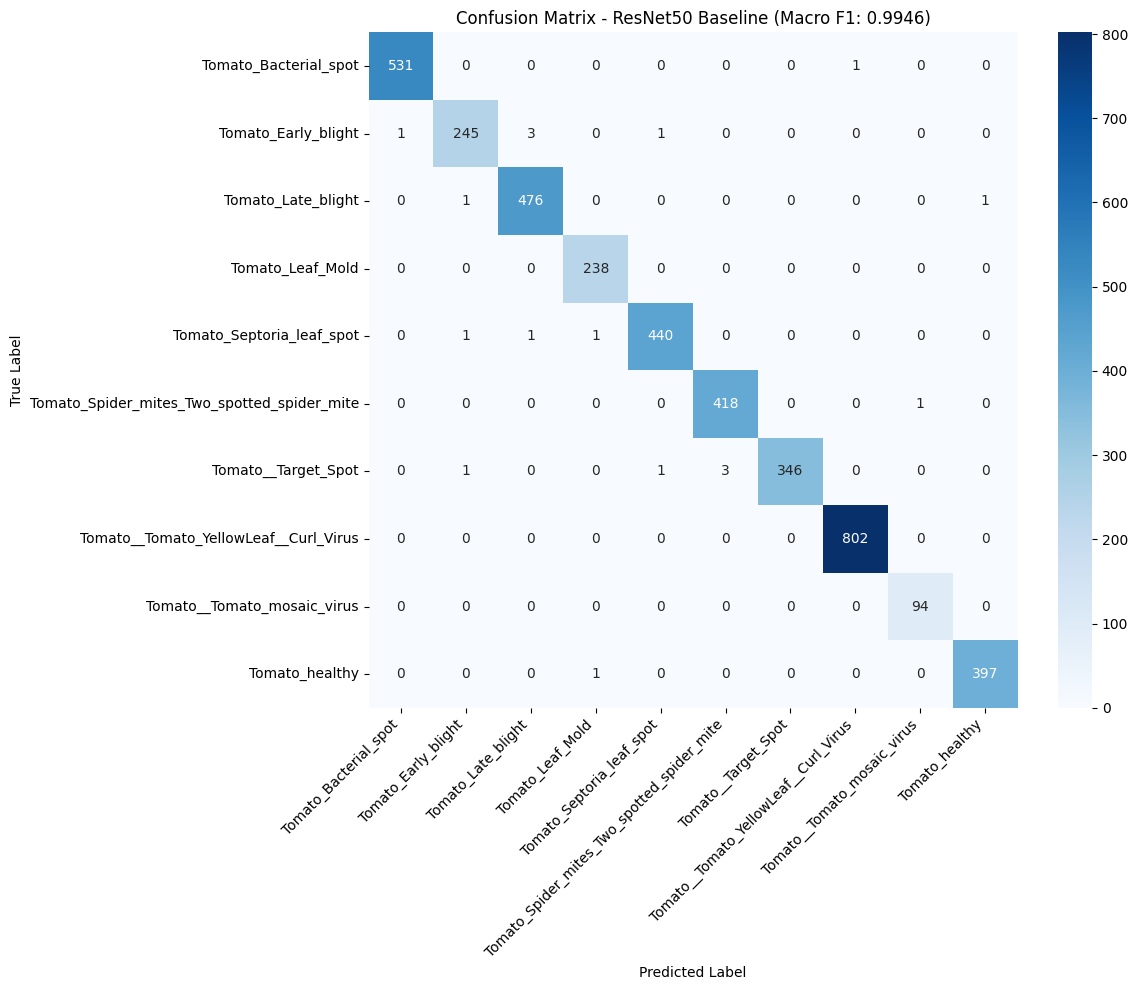


✅ Week 2 Baseline Complete!
Model saved: best_resnet50_checkpoint.pth | Plot: resnet50_confusion_matrix.png
Ready for Week 3 improvements!


In [31]:

# 1. Re-create model architecture (exact same as training)
model = models.resnet50(weights="DEFAULT")
model.fc = nn.Linear(model.fc.in_features, 10)  # 10 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. Load best checkpoint
checkpoint = torch.load('best_resnet50_checkpoint.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from Epoch {checkpoint['epoch']}, Val Acc: {checkpoint['best_acc']:.4f}")

# 3. Evaluation function
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"📊 **Macro F1-Score: {macro_f1:.4f}**")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - ResNet50 Baseline (Macro F1: {macro_f1:.4f})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('resnet50_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    return macro_f1, cm

# 4. Run evaluation
class_names = test_dataset.classes  # From your data loader
macro_f1, cm = evaluate_model(model, test_loader, class_names)

print("\n✅ Week 2 Baseline Complete!")
print(f"Model saved: best_resnet50_checkpoint.pth | Plot: resnet50_confusion_matrix.png")
print("Ready for Week 3 improvements!")


In [32]:
from google.colab import drive
import os
import json
import pandas as pd
import shutil
import torch

# 1. Mount Drive & Create folder
drive.mount('/content/drive')
drive_folder = '/content/drive/MyDrive/assignment_final'
os.makedirs(drive_folder, exist_ok=True)
print(f"✅ Folder: {drive_folder}")

# 2. Save missing files
json.dump(test_dataset.classes, open('classes.json', 'w'))
history_data = {
    'epoch': list(range(1,16)),
    'train_loss': [0.3407,0.1441,0.1207,0.0989,0.0856,0.0858,0.0738,0.0274,0.0199,0.0149,0.0146,0.0119,0.0107,0.0093,0.0073],
    'train_acc': [0.8915,0.9522,0.9593,0.9652,0.9714,0.9702,0.9748,0.9917,0.9932,0.9952,0.9958,0.9964,0.9968,0.9973,0.9981],
    'val_acc': [0.9476,0.9493,0.9655,0.9600,0.9785,0.9788,0.9645,0.9920,0.9935,0.9955,0.9953,0.9955,0.9943,0.9928,0.9943]
}
pd.DataFrame(history_data).to_csv('training_history.csv', index=False)
torch.save(model.state_dict(), 'resnet50_baseline.pth')

# 3. Copy ALL to Drive
files_to_save = [
    'best_resnet50_checkpoint.pth', 'resnet50_confusion_matrix.png',
    'classes.json', 'training_history.csv', 'resnet50_baseline.pth'
]
for f in files_to_save:
    if os.path.exists(f):
        shutil.copy(f, drive_folder)
        print(f"✅ Copied {f} → Drive")

print("Week 2 complete! Files in MyDrive/assignment_final/")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Folder: /content/drive/MyDrive/assignment_final
✅ Copied best_resnet50_checkpoint.pth → Drive
✅ Copied resnet50_confusion_matrix.png → Drive
✅ Copied classes.json → Drive
✅ Copied training_history.csv → Drive
✅ Copied resnet50_baseline.pth → Drive
Week 2 complete! Files in MyDrive/assignment_final/
